In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from tqdm import tqdm_notebook as tqdm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import grad
from torchvision.utils import make_grid


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Dataset/'

In [5]:
batch_size = 100
image_size = 64
n_class = 5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [25]:
dataset = datasets.ImageFolder(root=data_dir,transform=transforms.Compose([ transforms.Resize(image_size), transforms.RandomHorizontalFlip(), transforms.CenterCrop(image_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)


cuda:0


In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = get_default_device()
dataloader = DeviceDataLoader(dataloader, device)

In [56]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False))

In [51]:
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh())

In [55]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [52]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Norm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [53]:
discriminator.apply(weight_init)
generator.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [54]:
fake_images = generator(torch.randn(batch_size, latent_size, 1, 1))

In [57]:
def train_discriminator(real_images, optimizer):
    optimizer.zero_grad()
    real_preds = discriminator(real_images)
    real_loss = -torch.mean(real_preds)
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_preds = discriminator(fake_images)
    real_acc = (real_preds > 0.5).sum().item() / len(real_preds)
    fake_acc = (fake_preds < 0.5).sum().item() / len(fake_preds)
    total_acc = (real_acc + fake_acc) / 2
    fake_loss = torch.mean(fake_preds)
    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    return loss.item(), total_acc


def train_generator(optimizer):
    optimizer.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    loss = -torch.mean(preds)
    loss.backward()
    optimizer.step()
    fake_correct = (preds > 0.5).sum().item()
    total_correct = fake_correct
    total_acc = total_correct / len(fake_images)

    return loss.item(), total_acc

In [58]:
def train(epochs, lr):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    accs_d = []
    accs_g = []
    opt_discriminator = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_generator = torch.optim.RMSprop(generator.parameters(), lr=lr)
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            for parm in discriminator.parameters():
                parm.data.clamp_(-0.01, 0.01)
            loss_d, acc_d = train_discriminator(real_images, opt_discriminator)
            loss_g, acc_g = train_generator(opt_generator)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        accs_d.append(acc_d)
        accs_g.append(acc_g)
        print("Epoch [{}/{}]".format(
            epoch+1, epochs))
    return losses_g, losses_d, accs_d, accs_g

In [49]:
losses_g, losses_d, accs_d, accs_g = train(epochs=100, lr=0.0005)

<ipython-input-48-7e2c3b55ddee>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for real_images, _ in tqdm(dataloader):


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [87/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [89/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99/100]


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [100/100]


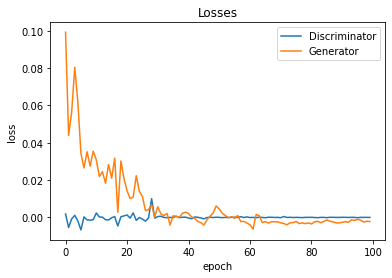

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');